<a href="https://colab.research.google.com/github/DylanHuynh/NBA-Regular-Season-Win-Rate-Predictor/blob/main/NBA_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro/Summary


In this project, our goal is to utilize historical NBA data from 1980 - 2018 to develop a prediction model for a team's regular season winrate during a specific year. Each team is represented by its top 3 guards and top 5 forwards/centers; Carefully-chosen individual statistics for these players from their previous season are used to predict a team's regular season W/L ratio. 

Our strategy revolves around the least squares approximation concept from linear algebra (covered in one of our recent courses at UC Berkeley, EECS 16a). Given a matrix-vector multiplication equation, $Ax\approx b$, where $A$ is a matrix and $x$ and $b$ are vectors, an approximation for the vector x can be attained using this formula: 

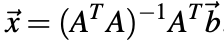

This concept is used in various machine learning applications such as determining a unique location using multiple GPS satellite signals.  

For our NBA performance prediction model, we fill each row of the $A$ matrix with statistics for the top 8 players on a specific team in a specific year. We have chosen 12 statistics to use for each player (including Player Efficiency Ratio, Win Shares, Box Plus-Minus, our own statistic called the "Synergy Score", and others). One row will therefore contain 12 statistics for each of the 3 guards and 5 forwards, appended together with a constant term added at the end. Each value in the $b$ vector is the corresponding regular season winrate for the team during that year.

Below, you'll find our setup of $Ax \approx b$. In the $A$matrix, the term $statsT_iT_j$ designates the stats for the top 3 guards and 5 forwards of the first team alphabetically in the first recorded year of 1981. The term $statG_i/F_j$ details the ith stat (ex. TOV%, TRB%, PER) in the jth position player (1-3 are guards, 4-8 are forwards). The b column is composed of $win\%T_iY_j$ following the same format as the subscripts of the stats terms, giving the winrate of a specific team in a specific year.

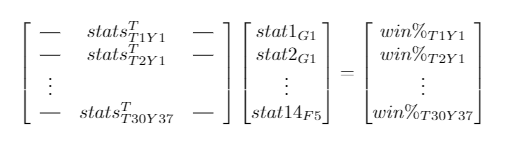

We then perform the aforementioend least squares method on the training set to find the vector $x$, which we then use on data from teams/years designated to the test set to produce predictions of their regular season W/L%. 

Below, you'll find a table containing NBA regular season performance predictions for the 1983-84 and 2011-2012 seasons:










In [18]:

import numpy as np
from datascience import *
import pandas
from IPython.display import Image 

preview = Table.read_table('/content/sample_years.csv')
preview.sort("Actual",descending=True).sort("Season").show(49)


Season,Team,Actual,Predicted,Actual - Predicted,(Actual-Predicted)/Predicted,Accurate
1984,Boston Celtics,0.756,0.686233,0.0697673,-0.0922848,True
1984,Philadelphia 76ers,0.634,0.706825,-0.0728254,0.114867,True
1984,Milwaukee Bucks,0.61,0.609743,0.000257417,-0.000421996,True
1984,Detroit Pistons,0.598,0.502888,0.0951123,-0.159051,True
1984,Portland Trail Blazers,0.585,0.577063,0.00793698,-0.0135675,True
1984,New York Knicks,0.573,0.586234,-0.0132345,0.0230968,True
1984,Utah Jazz,0.549,0.475184,0.0738161,-0.134456,True
1984,New Jersey Nets,0.549,0.609772,-0.0607719,0.110696,True
1984,Seattle SuperSonics,0.512,0.467952,0.0440485,-0.0860322,True
1984,Phoenix Suns,0.5,0.573387,-0.0733865,0.146773,True


In [19]:
preview.sort("Actual",descending=True).sort("Season").show(49)

Season,Team,Actual,Predicted,Actual - Predicted,(Actual-Predicted)/Predicted,Accurate
1984,Boston Celtics,0.756,0.686233,0.0697673,-0.0922848,True
1984,Philadelphia 76ers,0.634,0.706825,-0.0728254,0.114867,True
1984,Milwaukee Bucks,0.61,0.609743,0.000257417,-0.000421996,True
1984,Detroit Pistons,0.598,0.502888,0.0951123,-0.159051,True
1984,Portland Trail Blazers,0.585,0.577063,0.00793698,-0.0135675,True
1984,New York Knicks,0.573,0.586234,-0.0132345,0.0230968,True
1984,Utah Jazz,0.549,0.475184,0.0738161,-0.134456,True
1984,New Jersey Nets,0.549,0.609772,-0.0607719,0.110696,True
1984,Seattle SuperSonics,0.512,0.467952,0.0440485,-0.0860322,True
1984,Phoenix Suns,0.5,0.573387,-0.0733865,0.146773,True


In [20]:
stats = Table.read_table('/content/Seasons_Stats.csv')
records = Table.read_table('/content/Team_Records.csv')
forward_ranks = Table.read_table('/content/forward_ranks.csv')
guard_ranks = Table.read_table('/content/guard_ranks.csv')

In [21]:
Image("/content/Screenshot 2021-01-18 203308.png")

Rankings of Guards and Forwards

In [22]:
guard_ranks.show(15)
forward_ranks.show(15)

Player,Year,Team,Overall
Stephen Curry 1989.0,2017,Golden State Warriors,52.3956
Michael Jordan* 1964.0,1990,Chicago Bulls,50.5549
Michael Jordan* 1964.0,1992,Chicago Bulls,50.1781
Michael Jordan* 1964.0,1989,Chicago Bulls,49.9567
Magic Johnson* 1960.0,1990,Los Angeles Lakers,48.0057
Magic Johnson* 1960.0,1991,Los Angeles Lakers,47.1805
Michael Jordan* 1964.0,1991,Chicago Bulls,47.0746
Stephen Curry 1989.0,2016,Golden State Warriors,45.6791
Michael Jordan* 1964.0,1997,Chicago Bulls,45.3685
Manu Ginobili 1978.0,2013,San Antonio Spurs,45.2103


Player,Year,Team,Overall
LeBron James 1985.0,2010,Cleveland Cavaliers,39.1031
David Robinson* 1966.0,1995,San Antonio Spurs,33.8102
Shaquille O'Neal* 1973.0,2001,Los Angeles Lakers,31.6839
LeBron James 1985.0,2011,Miami Heat,31.1199
LeBron James 1985.0,2009,Cleveland Cavaliers,29.998
David Robinson* 1966.0,1998,San Antonio Spurs,29.8051
LeBron James 1985.0,2014,Miami Heat,29.456
Kevin Garnett 1977.0,2005,Minnesota Timberwolves,29.1688
LeBron James 1985.0,2013,Miami Heat,27.5336
David Robinson* 1966.0,1999,San Antonio Spurs,26.8038


# **Part 1: Cleaning the Data**

Here is the raw data we're working with:

In [23]:
stats.show(10)
records.show(10)

Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950,Curly Armstrong,G-F,31,FTW,63,nan,nan,nan,0.368,nan,0.467,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.1,3.6,3.5,nan,nan,nan,nan,nan,nan,144,516,0.279,nan,nan,nan,144,516,0.279,0.279,170,241,0.705,nan,nan,nan,176,nan,nan,nan,217,458
1,1950,Cliff Barker,SG,29,INO,49,nan,nan,nan,0.435,nan,0.387,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.6,0.6,2.2,nan,nan,nan,nan,nan,nan,102,274,0.372,nan,nan,nan,102,274,0.372,0.372,75,106,0.708,nan,nan,nan,109,nan,nan,nan,99,279
2,1950,Leo Barnhorst,SF,25,CHS,67,nan,nan,nan,0.394,nan,0.259,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.9,2.8,3.6,nan,nan,nan,nan,nan,nan,174,499,0.349,nan,nan,nan,174,499,0.349,0.349,90,129,0.698,nan,nan,nan,140,nan,nan,nan,192,438
3,1950,Ed Bartels,F,24,TOT,15,nan,nan,nan,0.312,nan,0.395,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.5,-0.1,-0.6,nan,nan,nan,nan,nan,nan,22,86,0.256,nan,nan,nan,22,86,0.256,0.256,19,34,0.559,nan,nan,nan,20,nan,nan,nan,29,63
4,1950,Ed Bartels,F,24,DNN,13,nan,nan,nan,0.308,nan,0.378,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.5,-0.1,-0.6,nan,nan,nan,nan,nan,nan,21,82,0.256,nan,nan,nan,21,82,0.256,0.256,17,31,0.548,nan,nan,nan,20,nan,nan,nan,27,59
5,1950,Ed Bartels,F,24,NYK,2,nan,nan,nan,0.376,nan,0.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,nan,nan,nan,nan,nan,nan,1,4,0.25,nan,nan,nan,1,4,0.25,0.25,2,3,0.667,nan,nan,nan,0,nan,nan,nan,2,4
6,1950,Ralph Beard,G,22,INO,60,nan,nan,nan,0.422,nan,0.301,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.6,1.2,4.8,nan,nan,nan,nan,nan,nan,340,936,0.363,nan,nan,nan,340,936,0.363,0.363,215,282,0.762,nan,nan,nan,233,nan,nan,nan,132,895
7,1950,Gene Berce,G-F,23,TRI,3,nan,nan,nan,0.275,nan,0.313,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.1,0,-0.1,nan,nan,nan,nan,nan,nan,5,16,0.313,nan,nan,nan,5,16,0.313,0.313,0,5,0,nan,nan,nan,2,nan,nan,nan,6,10
8,1950,Charlie Black,F-C,28,TOT,65,nan,nan,nan,0.346,nan,0.395,nan,nan,nan,nan,nan,nan,nan,nan,nan,-2.2,5,2.8,nan,nan,nan,nan,nan,nan,226,813,0.278,nan,nan,nan,226,813,0.278,0.278,209,321,0.651,nan,nan,nan,163,nan,nan,nan,273,661
9,1950,Charlie Black,F-C,28,FTW,36,nan,nan,nan,0.362,nan,0.48,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.7,2.2,1.5,nan,nan,nan,nan,nan,nan,125,435,0.287,nan,nan,nan,125,435,0.287,0.287,132,209,0.632,nan,nan,nan,75,nan,nan,nan,140,382


Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS
2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108,0.2,102.8,-5,nan,B. Stevens (29-10),K. Irving (5.7)
2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5)
2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7)
2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.4,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5)
2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1,nan,B. Stevens (25-57),B. Bass (5.1)
2012-13,NBA,Boston Celtics*,41,40,0.506,3,-0.62,91.7,-0.3,103.1,-2.8,103.3,-2.6,Lost E. Conf. 1st Rnd.,D. Rivers (41-40),P. Pierce (7.2)
2011-12,NBA,Boston Celtics*,39,27,0.591,1,2.26,90.4,-0.9,101,-3.6,98.2,-6.4,Lost E. Conf. Finals,D. Rivers (39-27),P. Pierce (7.0)
2010-11,NBA,Boston Celtics*,56,26,0.683,1,4.83,90.4,-1.7,106.2,-1.1,100.3,-7,Lost E. Conf. Semis,D. Rivers (56-26),P. Pierce (11.6)
2009-10,NBA,Boston Celtics*,50,32,0.61,1,3.37,91.6,-1.1,107.7,0.1,103.8,-3.8,Lost Finals,D. Rivers (50-32),R. Rondo (9.6)
2008-09,NBA,Boston Celtics*,62,20,0.756,1,7.44,90.4,-1.3,110.5,2.2,102.3,-6,Lost E. Conf. Semis,D. Rivers (62-20),R. Allen (11.1)


First, we are going to identify players who may have the same name and played during the same year by appending an identifier of the player's birth year onto their player name.

In [24]:
with_birth = stats.with_column("Birth year",stats.column("Year")-stats.column("Age"))
player_name_birth_year = stats.column("Player")
for i in range(len(player_name_birth_year)):
  player_name_birth_year[i] = player_name_birth_year[i] + " "+str(with_birth.column("Birth year").item(i))
with_birth_stats = stats.with_column("Player",player_name_birth_year)
#add birth year to player names because there are players with the exact same name who have played at the same time

Now we are going to clean up the records table by removing the asterisk at the end of each team's name if there

In [25]:
teams = records.column("Team")

for i in range(len(teams)):
  if teams[i][len(teams[i])-1] == '*':
    teams[i] = teams[i][:len(teams[i])-1]

records = records.with_column("Team",teams)
#remove *s

Removing 3 more special cases. First are the special case of players playing before 1980 and 1981, but not in 1980. Second are low minute players who played 6 or less minutes per game. Third are players who played less than 10 games in the season.

In [26]:


#special case: players who played before 1980 and played in 1981, but NOT in 1980
#causes bug since there are no stats for that player for predicting 1981
# ==> set the season before 1980 to 1980 for purposes of predicting 1981

#Keith Herron 5521
#Mychal Thompson 5688
#Ron Davis  4728

year_column = with_birth_stats.column("Year")
year_column[5521] = 1980
year_column[5688] = 1980
year_column[4728] = 1980


#remove people with less than 10 games and people who play less than 6 min/game
#add min/game column

with_birth_stats = with_birth_stats.with_column("Year",year_column).where("G",are.above(10))
with_birth_stats = with_birth_stats.with_columns("MPG",with_birth_stats.column("MP")/with_birth_stats.column("G")).where("MPG",are.above(6.1))


Now we are creating our stats to use as parameters for our model and appending those custom stats to our overall stats table as the per_game_stats table. Here are a variety of different stats we experimented with using (most of which did not make it into the final equation)

In [27]:
pre_stats = with_birth_stats.with_columns("PPG",with_birth_stats.column("PTS")/with_birth_stats.column("G"),"APG",with_birth_stats.column("AST")/with_birth_stats.column("G"),"RPG",with_birth_stats.column("TRB")/with_birth_stats.column("G"),"SPG",with_birth_stats.column("STL")/with_birth_stats.column("G"),"3PG",with_birth_stats.column("3P")/with_birth_stats.column("G"),"FPG",with_birth_stats.column("FT")/with_birth_stats.column("G"),"TPG",with_birth_stats.column("TOV")/with_birth_stats.column("G"),"BPG",with_birth_stats.column("BLK")/with_birth_stats.column("G")).with_columns("AGE_rating",with_birth_stats.column("Age")**2 - 56*with_birth_stats.column("Age"))


per_game_stats = pre_stats.with_columns(
                                        "AGE2",pre_stats.column("Age")**2,
                                        "AGE1",pre_stats.column("Age"),
                                        "PPM2",(pre_stats.column("PPG")**2)/pre_stats.column("MPG"),
                                        "PPM1",(pre_stats.column("PPG"))/pre_stats.column("MPG"),
                                        "RPM",(pre_stats.column("RPG"))/pre_stats.column("MPG"),
                                        "3PM",pre_stats.column("3PG")/pre_stats.column("MPG"),                           
                                        "PER/M",pre_stats.column("PER")*pre_stats.column("MPG"),
                                        "PER1",pre_stats.column("PER"),
                                        "WS2",pre_stats.column("WS")**2,
                                        "WS1",pre_stats.column("WS"),
                                        "USG2",pre_stats.column("USG%")**2,
                                        "USG1",pre_stats.column("USG%"),
                                        "PTS/FGA",pre_stats.column("PTS")/pre_stats.column("FGA"),
                                        "PFPG",pre_stats.column("PF")/pre_stats.column("G")
                                        )


per_game_stats = per_game_stats.sort("Year").sort("Player")

per_game_stats

#yield per game stats per player


Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MPG,PPG,APG,RPG,SPG,3PG,FPG,TPG,BPG,AGE_rating,AGE2,AGE1,PPM2,PPM1,RPM,3PM,PER/M,PER1,WS2,WS1,USG2,USG1,PTS/FGA,PFPG
8035,1986,A.C. Green 1964.0,PF,22,LAL,82,1,1542,11.8,0.564,0.015,0.43,12.4,15.5,14,4.2,1.5,1.7,17.7,14.7,nan,1.4,2,3.3,0.103,nan,-0.5,0.8,0.3,0.9,209,388,0.539,1,6,0.167,208,382,0.545,0.54,102,167,0.611,160,221,381,54,49,49,99,229,521,18.8049,6.35366,0.658537,4.64634,0.597561,0.0121951,1.2439,1.20732,0.597561,-748,484,22,2.14673,0.337873,0.247082,0.000648508,221.898,11.8,10.89,3.3,216.09,14.7,1.34278,2.79268
8420,1987,A.C. Green 1964.0,PF,23,LAL,79,72,2240,15.7,0.599,0.009,0.48,11.2,18.8,15.3,4.6,1.5,2,12.5,14.7,nan,4.3,3.3,7.6,0.163,nan,0.6,1,1.7,2.1,316,587,0.538,0,5,0,316,582,0.543,0.538,220,282,0.78,210,405,615,84,70,80,102,171,852,28.3544,10.7848,1.06329,7.78481,0.886076,0,2.78481,1.29114,1.01266,-759,529,23,4.10208,0.380357,0.274554,0,445.165,15.7,57.76,7.6,216.09,14.7,1.45145,2.16456
8807,1988,A.C. Green 1964.0,PF,24,LAL,82,64,2636,14.5,0.581,0.003,0.592,11.1,19.1,15.3,4.5,1.6,1,12.9,14.7,nan,4.5,3.4,7.9,0.144,nan,0.2,0.8,1,2,322,640,0.503,0,2,0,322,638,0.505,0.503,293,379,0.773,245,465,710,93,87,45,120,204,937,32.1463,11.4268,1.13415,8.65854,1.06098,0,3.57317,1.46341,0.54878,-768,576,24,4.06181,0.355463,0.269347,0,466.122,14.5,62.41,7.9,216.09,14.7,1.46406,2.4878
9242,1989,A.C. Green 1964.0,PF,25,LAL,82,82,2510,17.8,0.594,0.022,0.474,12.3,20,16.4,5.5,1.8,1.2,11.5,17,nan,5.8,3.5,9.4,0.179,nan,1.6,0.6,2.2,2.7,401,758,0.529,4,17,0.235,397,741,0.536,0.532,282,359,0.786,258,481,739,103,94,55,119,172,1088,30.6098,13.2683,1.2561,9.0122,1.14634,0.0487805,3.43902,1.45122,0.670732,-775,625,25,5.75136,0.433466,0.294422,0.00159363,544.854,17.8,88.36,9.4,289,17,1.43536,2.09756
9688,1990,A.C. Green 1964.0,PF,26,LAL,82,82,2709,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,nan,4.4,3.3,7.7,0.137,nan,0.3,0,0.4,1.6,385,806,0.478,13,46,0.283,372,760,0.489,0.486,278,370,0.751,262,450,712,90,66,50,116,207,1061,33.0366,12.939,1.09756,8.68293,0.804878,0.158537,3.39024,1.41463,0.609756,-780,676,26,5.06767,0.391657,0.262828,0.00479882,485.638,14.7,59.29,7.7,292.41,17.1,1.31638,2.52439
10166,1991,A.C. Green 1964.0,PF,27,LAL,82,21,2164,13.8,0.556,0.101,0.557,11.3,16.2,13.8,4.5,1.4,0.6,12.8,15.6,nan,3.2,2.9,6.1,0.135,nan,0,0.6,0.5,1.4,258,542,0.476,11,55,0.2,247,487,0.507,0.486,223,302,0.738,201,315,516,71,59,23,99,117,750,26.3902,9.14634,0.865854,6.29268,0.719512,0.134146,2.71951,1.20732,0.280488,-783,729,27,3.16994,0.34658,0.238447,0.00508318,364.185,13.8,37.21,6.1,243.36,15.6,1.38376,1.42683
10617,1992,A.C. Green 1964.0,PF,28,LAL,82,53,2902,16.7,0.556,0.07,0.569,11.8,18.2,14.9,6,1.6,0.8,10,16.8,nan,5.8,2.9,8.8,0.145,nan,1.2,0.2,1.4,2.5,382,803,0.476,12,56,0.214,370,747,0.495,0.483,340,457,0.744,306,456,762,117,91,36,111,141,1116,35.3902,13.6098,1.42683,9.29268,1.10976,0.146341,4.14634,1.35366,0.439024,-784,784,28,5.2338,0.384562,0.262578,0.00413508,591.017,16.7,77.44,8.8,282.24,16.8,1.38979,1.71951
11060,1993,A.C. Green 1964.0,PF,29,LAL,82,55,2819,16.3,0.603,0.065,0.531,11.5,17.3,14.4,5.9,1.6,0.9,11.8,15,nan,6.1,2.6,8.6,0.147,nan,1.6,0.5,2.1,2.9,379,706,0.537,16,46,0.348,363,660,0.55,0.548,277,375,0.739,287,424,711,116,88,39,116,149,1051,34.378,12.8171,1.41463,8.67073,1.07317,0.195122,3.37805,1.41463,0.47561,-783,841,29,4.77855,0.372827,0.252217,0.00567577,560.362,16.3,73.96,8.6,225,15,1.48867,1.81707
11529,1994,A.C. Green 1964.0,PF,30,PHO,82,55,2825,17,0.555,0.038,0.391,11.1,18.8,15,6.9,1.2,0.8,8.4,17.6,nan,6.7,2.6,9.3,0.157,nan,1.5,-0.3,1.2,2.3,465,926,0.502,8,35,0.229,457,891,0.513,0.506,266,362,0.735,275,478,753,137,70,38,100,142,1204,34.4512,14.6829,1.67073,9.18293,0.853659,0.097561,3.2439,1.21951,0.463415,-780,900,30,6.25779,0.426195,0.266549,0.00283186,585.671,17,86.49,9.3,309.76,1

Splitting the stats table into 2 categories: per_game_stats_previous which has the stats from 1980-2017 which we'll use to obtain all the previous year's stats of a player to use for prediction and per_game_stats_current which uses 1981-2017 which we'll use to find the current team's roster to select previous year stats from. Then we filter out the rookies from the "current" table since we can't access previous years of rookies since they didn't play in the NBA.

In [28]:
per_game_stats_previous = per_game_stats.where("Year",are.between(1980,2018))
per_game_stat_current = per_game_stats.where("Year",are.between(1981,2018))

take_indices = []

i = 1
exists_before_TOT = False

while i < per_game_stat_current.num_rows:

  if exists_before_TOT and per_game_stat_current.column("Year").item(i-1) != per_game_stat_current.column("Year").item(i):
    exists_before_TOT = False
  if per_game_stat_current.column("Tm").item(i) == "TOT" and per_game_stat_current.column("Player").item(i-1) == per_game_stat_current.column("Player").item(i):
    exists_before_TOT = True
  if per_game_stat_current.column("Player").item(i)== per_game_stat_current.column("Player").item(i-1) and (per_game_stat_current.column("Year").item(i) != per_game_stat_current.column("Year").item(i-1) or exists_before_TOT):
    take_indices.append(i)
  
  i+=1
#removed rookie years of all players
no_rookies_stats = per_game_stat_current.take(take_indices)


Taking the "current" year stats and splitting them up into forwards and guards tables for each team in the "current" year

In [29]:
time_filtered_stats = per_game_stats_previous
forwards = no_rookies_stats.sort("Year").sort("Tm").where("Pos",are.contained_in("SF-PF-C"))
guards = no_rookies_stats.sort("Year").sort("Tm").where("Pos",are.contained_in("PG-SG"))
forwards.show(10)
guards.show(10)
# got the forwards and guards table


Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MPG,PPG,APG,RPG,SPG,3PG,FPG,TPG,BPG,AGE_rating,AGE2,AGE1,PPM2,PPM1,RPM,3PM,PER/M,PER1,WS2,WS1,USG2,USG1,PTS/FGA,PFPG
6741,1982,Dan Roundfield 1954.0,PF,28,ATL,61,58,2217,19.5,0.527,0.005,0.412,11.6,25.3,18.4,11.9,1.5,2.6,14.5,24.6,nan,2.4,4.1,6.5,0.141,nan,0.8,2.5,3.3,2.9,424,910,0.466,1,5,0.2,423,905,0.467,0.466,285,375,0.76,227,494,721,162,64,93,183,210,1134,36.3443,18.5902,2.65574,11.8197,1.04918,0.0163934,4.67213,3,1.52459,-784,784,28,9.50891,0.511502,0.325214,0.00045106,708.713,19.5,42.25,6.5,605.16,24.6,1.24615,3.44262
6535,1982,John Drew 1955.0,SF,27,ATL,70,51,2040,18.1,0.553,0.013,0.513,9.3,11.5,10.4,8.1,1.6,0.1,13.2,28.7,nan,3.2,2.4,5.5,0.13,nan,1.4,-1.6,-0.1,1,465,957,0.486,4,12,0.333,461,945,0.488,0.488,364,491,0.741,169,206,375,96,64,3,178,250,1298,29.1429,18.5429,1.37143,5.35714,0.914286,0.0571429,5.2,2.54286,0.0428571,-783,729,27,11.7983,0.636275,0.183824,0.00196078,527.486,18.1,30.25,5.5,823.69,28.7,1.35632,3.57143
6714,1982,Sam Pellom 1952.0,PF,30,ATL,69,4,1037,10.3,0.506,0.004,0.315,9.8,15.2,12.5,3.9,1.4,2.8,16.6,14.3,nan,0.2,1.6,1.8,0.083,nan,-2.9,1.5,-1.4,0.2,114,251,0.454,0,1,0,114,250,0.456,0.454,61,79,0.772,90,139,229,28,29,47,57,164,289,15.029,4.18841,0.405797,3.31884,0.42029,0,0.884058,0.826087,0.681159,-780,900,30,1.16726,0.278689,0.220829,0,154.799,10.3,3.24,1.8,204.49,14.3,1.15139,2.37681
6576,1982,Steve Hawes 1951.0,PF,31,ATL,49,42,1317,14.5,0.536,0.027,0.341,7.6,19.9,13.7,16,1.4,1.6,17,16.9,nan,1.2,2.1,3.2,0.118,nan,-0.2,2.5,2.2,1.4,178,370,0.481,4,10,0.4,174,360,0.483,0.486,96,126,0.762,89,231,320,142,36,34,87,156,456,26.8776,9.30612,2.89796,6.53061,0.734694,0.0816327,1.95918,1.77551,0.693878,-775,961,31,3.22217,0.346241,0.242976,0.00303721,389.724,14.5,10.24,3.2,285.61,16.9,1.23243,3.18367
6685,1982,Tom McMillen 1953.0,C,29,ATL,73,23,1792,13.1,0.559,0.005,0.297,6.4,14.8,10.6,11.2,0.7,0.8,16.1,18.7,nan,1.7,2,3.7,0.099,nan,-0.7,0.2,-0.5,0.7,291,572,0.509,1,3,0.333,290,569,0.51,0.51,140,170,0.824,102,234,336,129,25,24,124,202,723,24.5479,9.90411,1.76712,4.60274,0.342466,0.0136986,1.91781,1.69863,0.328767,-783,841,29,3.99591,0.40346,0.1875,0.000558036,321.578,13.1,13.69,3.7,349.69,18.7,1.26399,2.76712
6739,1982,Tree Rollins 1956.0,C,26,ATL,79,39,2018,14.7,0.6,0,0.373,9.4,24.9,17.1,4.1,0.9,6.8,16.4,10.4,nan,2.2,4.2,6.4,0.153,nan,-1.8,4.9,3.1,2.6,202,346,0.584,0,0,nan,202,346,0.584,0.584,79,129,0.612,168,443,611,59,35,224,79,285,483,25.5443,6.11392,0.746835,7.73418,0.443038,0,1,1,2.83544,-780,676,26,1.46334,0.239346,0.302775,0,375.501,14.7,40.96,6.4,108.16,10.4,1.39595,3.60759
7117,1983,Dan Roundfield 1954.0,PF,29,ATL,77,76,2811,18.8,0.526,0.023,0.377,9.8,23.4,16.6,12.4,1,2.3,15,24.2,nan,2.9,4.5,7.4,0.127,nan,0.7,1.7,2.4,3.1,561,1193,0.47,5,27,0.185,556,1166,0.477,0.472,337,450,0.749,259,621,880,225,60,115,245,239,1464,36.5065,19.013,2.92208,11.4286,0.779221,0.0649351,4.37662,3.18182,1.49351,-783,841,29,9.90217,0.520811,0.313056,0.00177873,686.322,18.8,54.76,7.4,585.64,24.2,1.22716,3.1039
6981,1983,George Johnson 1949.0,C,34,ATL,37,0,461,10.8,0.49,0,0.333,10.2,16.8,13.5,4.6,1.1,7.2,22.5,7.6,nan,0.1,0.8,1,0.1,nan,-3.5,5.1,1.6,0.4,25,57,0.439,0,0,nan,25,57,0.439,0.439,14,19,0.737,44,73,117,17,10,59,19,69,64,12.4595,1.72973,0.459459,3.16216,0.27027,0,0.378378,0.513514,1.59459,-748,1156,34,0.240136,0.138829,0.253796,0,134.562,10.8,1,1,57.76,7.6,1.12281,1.86486
6861,1983,Rickey Brown 1959.0,C,24,ATL,26,0,305,12.4,0.506,0.01,0.385,12.2,18.4,15.3,4.3,0.8,0.9,15.3,19.6,nan,0.1,0.4,0.5,0.077,nan,-2.6,-1.7,-4.3,-0.2,49,104,0.471,0,1,0,49,103,0.476,0.471,25,40,0.625,35,53,88,9,5,5,22,46,123,11.7308,4.73077,0.346154,3.38462,0.192308,0,0.961538,0.846154,0.192308,-768,576,24,1.90782,0.403279,0.288525,0,145.462,12.4,0.25,0.5,384.16,19.6,1.18269,1.76923
7041,1983,Rudy Macklin 1959.0,SF,24,A

Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MPG,PPG,APG,RPG,SPG,3PG,FPG,TPG,BPG,AGE_rating,AGE2,AGE1,PPM2,PPM1,RPM,3PM,PER/M,PER1,WS2,WS1,USG2,USG1,PTS/FGA,PFPG
6515,1982,Charlie Criss 1949.0,PG,33,ATL,27,0,552,13.6,0.485,0.038,0.348,1.2,6.6,3.9,20.7,2.1,0.2,11,21.4,nan,0.4,0.6,1,0.089,nan,-1.2,-1.3,-2.5,-0.1,84,210,0.4,2,8,0.25,82,202,0.406,0.405,65,73,0.89,6,32,38,75,23,2,30,40,235,20.4444,8.7037,2.77778,1.40741,0.851852,0.0740741,2.40741,1.11111,0.0740741,-759,1089,33,3.70538,0.425725,0.0688406,0.00362319,278.044,13.6,1,1,457.96,21.4,1.11905,1.48148
6605,1982,Eddie Johnson 1956.0,SG,26,ATL,68,57,2314,16.5,0.513,0.03,0.381,3.1,6.3,4.7,25.3,2.2,0.4,13.6,25.6,nan,2.2,2.6,4.8,0.1,nan,1.4,-0.5,0.9,1.7,455,1011,0.45,7,30,0.233,448,981,0.457,0.454,294,385,0.764,63,128,191,358,102,16,186,188,1211,34.0294,17.8088,5.26471,2.80882,1.5,0.102941,4.32353,2.73529,0.235294,-780,676,26,9.32,0.523336,0.0825411,0.00302506,561.485,16.5,23.04,4.8,655.36,25.6,1.19782,2.76471
6802,1982,Freeman Williams 1957.0,SG,25,ATL,23,0,189,11.2,0.453,0.182,0.236,1.2,6,3.6,17.2,1.6,0,12.9,32,nan,-0.2,0.2,-0.1,-0.018,nan,-2.9,-4.1,-7.1,-0.2,42,110,0.382,4,20,0.2,38,90,0.422,0.4,22,26,0.846,2,10,12,19,6,0,18,18,110,8.21739,4.78261,0.826087,0.521739,0.26087,0.173913,0.956522,0.782609,0,-775,625,25,2.78353,0.582011,0.0634921,0.021164,92.0348,11.2,0.01,-0.1,1024,32,1,0.782609
6679,1982,Jim McElroy 1954.0,PG,28,ATL,20,17,349,9.3,0.476,0.04,0.288,1.9,3.6,2.8,17,1.2,0.5,13.5,20.2,nan,0,0.3,0.3,0.036,nan,-2.8,-2.2,-5.1,-0.3,52,125,0.416,1,5,0.2,51,120,0.425,0.42,29,36,0.806,6,11,17,39,8,3,22,44,134,17.45,6.7,1.95,0.85,0.4,0.05,1.45,1.1,0.15,-784,784,28,2.57249,0.383954,0.0487106,0.00286533,162.285,9.3,0.09,0.3,408.04,20.2,1.072,2.2
6559,1982,Mike Glenn 1956.0,SG,26,ATL,49,0,833,16,0.587,0.007,0.23,0.7,7.6,4.1,16.9,1.6,0.2,7.8,18.1,nan,2,0.8,2.8,0.161,nan,0.9,-1.3,-0.5,0.3,158,291,0.543,1,2,0.5,157,289,0.543,0.545,59,67,0.881,5,56,61,87,26,3,27,80,376,17,7.67347,1.77551,1.2449,0.530612,0.0204082,1.20408,0.55102,0.0612245,-780,676,26,3.46365,0.451381,0.0732293,0.00120048,272,16,7.84,2.8,327.61,18.1,1.2921,1.63265
6762,1982,Rory Sparrow 1959.0,PG,23,ATL,82,82,2610,13,0.539,0.021,0.203,2.3,7.4,4.9,24.4,1.7,0.3,15.4,15.6,nan,2.9,2.7,5.6,0.104,nan,0.2,0.1,0.3,1.5,366,730,0.501,1,15,0.067,365,715,0.51,0.502,124,148,0.838,53,171,224,424,87,13,145,240,857,31.8293,10.4512,5.17073,2.73171,1.06098,0.0121951,1.5122,1.76829,0.158537,-759,529,23,3.43168,0.328352,0.0858238,0.000383142,413.78,13,31.36,5.6,243.36,15.6,1.17397,2.92683
6673,1982,Wes Matthews 1960.0,PG,22,ATL,47,5,837,12.6,0.487,0.027,0.265,2.6,5.3,3.9,25.5,3.2,0.1,15.9,20.5,nan,0.2,1.1,1.3,0.073,nan,-1.1,-0.5,-1.6,0.1,131,298,0.44,2,8,0.25,129,290,0.445,0.443,60,79,0.759,19,39,58,139,53,2,63,129,324,17.8085,6.89362,2.95745,1.23404,1.12766,0.0425532,1.2766,1.34043,0.0425532,-748,484,22,2.6685,0.387097,0.0692951,0.00238949,224.387,12.6,1.69,1.3,420.25,20.5,1.08725,2.74468
6978,1983,Eddie Johnson 1956.0,SG,27,ATL,61,57,1813,16,0.508,0.048,0.276,1.5,5.7,3.6,27.7,1.6,0.2,13.9,25.7,nan,1.6,1.5,3,0.081,nan,0.9,-2.2,-1.3,0.3,389,858,0.453,14,41,0.341,375,817,0.459,0.462,186,237,0.785,26,98,124,318,61,6,156,138,978,29.7213,16.0328,5.21311,2.03279,1,0.229508,3.04918,2.55738,0.0983607,-783,729,27,8.64868,0.539437,0.0683949,0.00772201,475.541,16,9,3,660.49,25.7,1.13986,2.2623
6898,1983,Johnny Davis 1956.0,SG,27,ATL,53,33,1465,16.8,0.521,0.032,0.363,2.7,6.6,4.6,32,1.4,0.3,14.8,21.9,nan,2.3,1.2,3.5,0.113,nan,1.3,-1.9,-0.6,0.5,258,567,0.455,5,18,0.278,253,549,0.461,0.459,164,206,0.796,37,91,128,315,43,7,114,100,685,27.6415,12.9245,5.9434,2.41509,0.811321,0.0943396,3.09434,2.15094,0.132075,-783,729,27,6.04321,0.467577,0.087372,0.00341297,464.377,16.8,12.25,3.5,479.61,21.9,1.20811,1.88679
6939,1983,Mike Glenn 1956.0,SG,27,ATL,73,4,1124,15.1,0.553,0.002,

Now we alter the guards and forwards table, where if a team in a year has at least 3 guards or at least 5 forwards, we keep that team.

In [30]:
remove = []

def findHighestMPG(tbl,x):
  tbl = tbl.with_columns("MPG",tbl.column("MP")/tbl.column("G"))
  indices_array = []
  i = 0
  tbl = tbl.sort("MPG",descending=True).sort("Year").sort("Tm")
  while i < tbl.num_rows:
    year = tbl.column("Year").item(i)
    count = 0
    while i < tbl.num_rows and year == tbl.column("Year").item(i):
      if count < x:
        indices_array.append(i)
        count+=1
      i+=1
    if count!=x:
      remove.append(tbl.column("Tm").item(i-1) +" " + str(tbl.column("Year").item(i-1)))
  return tbl.take(indices_array)

findHighestMPG(guards,3)
findHighestMPG(forwards,5)
# just fills the remove array, doesn't affect guards or forwards yet

team_year_guards = guards.with_column("Team/Year", guards.apply(lambda x,y: x+" "+str(y),"Tm","Year"))
team_year_forwards = forwards.with_column("Team/Year", forwards.apply(lambda x,y: x+" "+str(y),"Tm","Year"))
least_three_guards = team_year_guards.where("Team/Year", are.not_contained_in(remove))
least_five_forwards = team_year_forwards.where("Team/Year", are.not_contained_in(remove))
#isolates only the teams with that have at least 3 and 5 guards and forwards that played last season

Taking those guards and forwards tables and truncating them to only include 3 guards and 5 forwards per team

In [31]:
only_three_guards = findHighestMPG(least_three_guards,3)
only_five_forwards = findHighestMPG(least_five_forwards,5)
only_three_guards.show(12)
only_five_forwards.show(20)
#finds 3 guard 5 forward combos for each valid team in the PREDICTED current year

Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MPG,PPG,APG,RPG,SPG,3PG,FPG,TPG,BPG,AGE_rating,AGE2,AGE1,PPM2,PPM1,RPM,3PM,PER/M,PER1,WS2,WS1,USG2,USG1,PTS/FGA,PFPG,Team/Year
6605,1982,Eddie Johnson 1956.0,SG,26,ATL,68,57,2314,16.5,0.513,0.03,0.381,3.1,6.3,4.7,25.3,2.2,0.4,13.6,25.6,nan,2.2,2.6,4.8,0.1,nan,1.4,-0.5,0.9,1.7,455,1011,0.45,7,30,0.233,448,981,0.457,0.454,294,385,0.764,63,128,191,358,102,16,186,188,1211,34.0294,17.8088,5.26471,2.80882,1.5,0.102941,4.32353,2.73529,0.235294,-780,676,26,9.32,0.523336,0.0825411,0.00302506,561.485,16.5,23.04,4.8,655.36,25.6,1.19782,2.76471,ATL 1982.0
6762,1982,Rory Sparrow 1959.0,PG,23,ATL,82,82,2610,13,0.539,0.021,0.203,2.3,7.4,4.9,24.4,1.7,0.3,15.4,15.6,nan,2.9,2.7,5.6,0.104,nan,0.2,0.1,0.3,1.5,366,730,0.501,1,15,0.067,365,715,0.51,0.502,124,148,0.838,53,171,224,424,87,13,145,240,857,31.8293,10.4512,5.17073,2.73171,1.06098,0.0121951,1.5122,1.76829,0.158537,-759,529,23,3.43168,0.328352,0.0858238,0.000383142,413.78,13,31.36,5.6,243.36,15.6,1.17397,2.92683,ATL 1982.0
6515,1982,Charlie Criss 1949.0,PG,33,ATL,27,0,552,13.6,0.485,0.038,0.348,1.2,6.6,3.9,20.7,2.1,0.2,11,21.4,nan,0.4,0.6,1,0.089,nan,-1.2,-1.3,-2.5,-0.1,84,210,0.4,2,8,0.25,82,202,0.406,0.405,65,73,0.89,6,32,38,75,23,2,30,40,235,20.4444,8.7037,2.77778,1.40741,0.851852,0.0740741,2.40741,1.11111,0.0740741,-759,1089,33,3.70538,0.425725,0.0688406,0.00362319,278.044,13.6,1,1,457.96,21.4,1.11905,1.48148,ATL 1982.0
7147,1983,Rory Sparrow 1959.0,PG,24,ATL,49,49,1548,13.7,0.547,0.029,0.221,2.7,7,4.8,22.7,2.2,0,18.3,18.5,nan,1.2,1.6,2.8,0.087,nan,0.4,-0.2,0.2,0.8,264,512,0.516,3,15,0.2,261,497,0.525,0.519,84,113,0.743,39,102,141,238,70,1,126,162,615,31.5918,12.551,4.85714,2.87755,1.42857,0.0612245,1.71429,2.57143,0.0204082,-768,576,24,4.98636,0.397287,0.0910853,0.00193798,432.808,13.7,7.84,2.8,342.25,18.5,1.20117,3.30612,ATL 1983.0
6978,1983,Eddie Johnson 1956.0,SG,27,ATL,61,57,1813,16,0.508,0.048,0.276,1.5,5.7,3.6,27.7,1.6,0.2,13.9,25.7,nan,1.6,1.5,3,0.081,nan,0.9,-2.2,-1.3,0.3,389,858,0.453,14,41,0.341,375,817,0.459,0.462,186,237,0.785,26,98,124,318,61,6,156,138,978,29.7213,16.0328,5.21311,2.03279,1,0.229508,3.04918,2.55738,0.0983607,-783,729,27,8.64868,0.539437,0.0683949,0.00772201,475.541,16,9,3,660.49,25.7,1.13986,2.2623,ATL 1983.0
6898,1983,Johnny Davis 1956.0,SG,27,ATL,53,33,1465,16.8,0.521,0.032,0.363,2.7,6.6,4.6,32,1.4,0.3,14.8,21.9,nan,2.3,1.2,3.5,0.113,nan,1.3,-1.9,-0.6,0.5,258,567,0.455,5,18,0.278,253,549,0.461,0.459,164,206,0.796,37,91,128,315,43,7,114,100,685,27.6415,12.9245,5.9434,2.41509,0.811321,0.0943396,3.09434,2.15094,0.132075,-783,729,27,6.04321,0.467577,0.087372,0.00341297,464.377,16.8,12.25,3.5,479.61,21.9,1.20811,1.88679,ATL 1983.0
7344,1984,Eddie Johnson 1956.0,SG,28,ATL,67,43,1893,14.2,0.497,0.054,0.267,1.8,7,4.4,31.5,1.5,0.2,16.2,24.3,nan,0.3,1.4,1.7,0.044,nan,-0.1,-2,-2.2,-0.1,353,798,0.442,16,43,0.372,337,755,0.446,0.452,164,213,0.77,31,115,146,374,58,7,173,155,886,28.2537,13.2239,5.58209,2.1791,0.865672,0.238806,2.44776,2.58209,0.104478,-784,784,28,6.18931,0.46804,0.0771263,0.00845219,401.203,14.2,2.89,1.7,590.49,24.3,1.11028,2.31343,ATL 1984.0
7277,1984,Johnny Davis 1956.0,PG,28,ATL,75,72,2079,14.3,0.507,0.01,0.32,2.9,4.8,3.8,24.4,1.5,0.2,12.8,21.7,nan,1.9,1.4,3.3,0.075,nan,0.1,-1.9,-1.8,0.1,354,800,0.443,0,8,0,354,792,0.447,0.443,217,256,0.848,53,86,139,326,62,6,134,146,925,27.72,12.3333,4.34667,1.85333,0.826667,0,2.89333,1.78667,0.08,-784,784,28,5.48741,0.444925,0.0668591,0,396.396,14.3,10.89,3.3,470.89,21.7,1.15625,1.94667,ATL 1984.0
7313,1984,Mike Glenn 1956.0,SG,28,ATL,81,0,1503,15.5,0.582,0.004,0.126,1.3,6.7,4,18.8,1.5,0.2,9.7,18.6,nan,2.8,1.1,3.9,0.124,nan,1,-1.8,-0.9,0.4,312,554,0.563,1,2,0.5,311,552,0.563,0.564,56,70,0.8,17,87,104,171,46,5,63,146,681,18.5556,8.40741,2.11111,1.28395,0.567901,0.0123457,0.691358,0.777778

Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MPG,PPG,APG,RPG,SPG,3PG,FPG,TPG,BPG,AGE_rating,AGE2,AGE1,PPM2,PPM1,RPM,3PM,PER/M,PER1,WS2,WS1,USG2,USG1,PTS/FGA,PFPG,Team/Year
6741,1982,Dan Roundfield 1954.0,PF,28,ATL,61,58,2217,19.5,0.527,0.005,0.412,11.6,25.3,18.4,11.9,1.5,2.6,14.5,24.6,nan,2.4,4.1,6.5,0.141,nan,0.8,2.5,3.3,2.9,424,910,0.466,1,5,0.2,423,905,0.467,0.466,285,375,0.76,227,494,721,162,64,93,183,210,1134,36.3443,18.5902,2.65574,11.8197,1.04918,0.0163934,4.67213,3,1.52459,-784,784,28,9.50891,0.511502,0.325214,0.00045106,708.713,19.5,42.25,6.5,605.16,24.6,1.24615,3.44262,ATL 1982.0
6535,1982,John Drew 1955.0,SF,27,ATL,70,51,2040,18.1,0.553,0.013,0.513,9.3,11.5,10.4,8.1,1.6,0.1,13.2,28.7,nan,3.2,2.4,5.5,0.13,nan,1.4,-1.6,-0.1,1,465,957,0.486,4,12,0.333,461,945,0.488,0.488,364,491,0.741,169,206,375,96,64,3,178,250,1298,29.1429,18.5429,1.37143,5.35714,0.914286,0.0571429,5.2,2.54286,0.0428571,-783,729,27,11.7983,0.636275,0.183824,0.00196078,527.486,18.1,30.25,5.5,823.69,28.7,1.35632,3.57143,ATL 1982.0
6576,1982,Steve Hawes 1951.0,PF,31,ATL,49,42,1317,14.5,0.536,0.027,0.341,7.6,19.9,13.7,16,1.4,1.6,17,16.9,nan,1.2,2.1,3.2,0.118,nan,-0.2,2.5,2.2,1.4,178,370,0.481,4,10,0.4,174,360,0.483,0.486,96,126,0.762,89,231,320,142,36,34,87,156,456,26.8776,9.30612,2.89796,6.53061,0.734694,0.0816327,1.95918,1.77551,0.693878,-775,961,31,3.22217,0.346241,0.242976,0.00303721,389.724,14.5,10.24,3.2,285.61,16.9,1.23243,3.18367,ATL 1982.0
6739,1982,Tree Rollins 1956.0,C,26,ATL,79,39,2018,14.7,0.6,0,0.373,9.4,24.9,17.1,4.1,0.9,6.8,16.4,10.4,nan,2.2,4.2,6.4,0.153,nan,-1.8,4.9,3.1,2.6,202,346,0.584,0,0,nan,202,346,0.584,0.584,79,129,0.612,168,443,611,59,35,224,79,285,483,25.5443,6.11392,0.746835,7.73418,0.443038,0,1,1,2.83544,-780,676,26,1.46334,0.239346,0.302775,0,375.501,14.7,40.96,6.4,108.16,10.4,1.39595,3.60759,ATL 1982.0
6685,1982,Tom McMillen 1953.0,C,29,ATL,73,23,1792,13.1,0.559,0.005,0.297,6.4,14.8,10.6,11.2,0.7,0.8,16.1,18.7,nan,1.7,2,3.7,0.099,nan,-0.7,0.2,-0.5,0.7,291,572,0.509,1,3,0.333,290,569,0.51,0.51,140,170,0.824,102,234,336,129,25,24,124,202,723,24.5479,9.90411,1.76712,4.60274,0.342466,0.0136986,1.91781,1.69863,0.328767,-783,841,29,3.99591,0.40346,0.1875,0.000558036,321.578,13.1,13.69,3.7,349.69,18.7,1.26399,2.76712,ATL 1982.0
7117,1983,Dan Roundfield 1954.0,PF,29,ATL,77,76,2811,18.8,0.526,0.023,0.377,9.8,23.4,16.6,12.4,1,2.3,15,24.2,nan,2.9,4.5,7.4,0.127,nan,0.7,1.7,2.4,3.1,561,1193,0.47,5,27,0.185,556,1166,0.477,0.472,337,450,0.749,259,621,880,225,60,115,245,239,1464,36.5065,19.013,2.92208,11.4286,0.779221,0.0649351,4.37662,3.18182,1.49351,-783,841,29,9.90217,0.520811,0.313056,0.00177873,686.322,18.8,54.76,7.4,585.64,24.2,1.22716,3.1039,ATL 1983.0
7115,1983,Tree Rollins 1956.0,C,27,ATL,80,80,2472,15.4,0.543,0.002,0.264,9.1,22.8,16,4.1,1,7.8,14.3,11.2,nan,2.3,5,7.3,0.142,nan,-1.8,5.4,3.6,3.5,261,512,0.51,0,1,0,261,511,0.511,0.51,98,135,0.726,210,533,743,75,49,343,95,294,620,30.9,7.75,0.9375,9.2875,0.6125,0,1.225,1.1875,4.2875,-783,729,27,1.94377,0.250809,0.300566,0,475.86,15.4,53.29,7.3,125.44,11.2,1.21094,3.675,ATL 1983.0
7056,1983,Tom McMillen 1953.0,C,30,ATL,61,4,1364,10.8,0.522,0.002,0.314,4.5,12.4,8.5,7.9,0.6,1,14.2,17.2,nan,0.7,1.3,2,0.071,nan,-2.2,-0.4,-2.5,-0.2,198,424,0.467,0,1,0,198,423,0.468,0.467,108,133,0.812,57,160,217,76,17,24,80,143,504,22.3607,8.2623,1.2459,3.55738,0.278689,0,1.77049,1.31148,0.393443,-780,900,30,3.05293,0.369501,0.159091,0,241.495,10.8,4,2,295.84,17.2,1.18868,2.34426,ATL 1983.0
6956,1983,Steve Hawes 1951.0,PF,32,ATL,46,3,860,8,0.424,0.057,0.254,6.6,21.5,14.1,9.3,1.6,0.5,21.2,16.7,nan,-1.2,1.3,0.1,0.006,nan,-4.9,1.2,-3.7,-0.4,91,244,0.373,2,14,0.143,89,230,0.387,0.377,46,62,0.742,53,175,228,59,29,8,73,110,230,18.6957,5,1.28261,4.95652,0.630435,0.0434783,1,1.58696,0.173913,-768,1024,32,1.33721,0.267442,0.265116,0.

Taking the previous year's stats table and removing the years of players who played for multiple teams in one year, only keeping the "TOT" row that averages the year's stats.

In [32]:
keep_indices = []
i = 0
while i < time_filtered_stats.num_rows:
  keep_indices.append(i)
  player = time_filtered_stats.column("Player").item(i)
  if time_filtered_stats.column("Tm").item(i) == "TOT":
    year = time_filtered_stats.column("Year").item(i)
    while time_filtered_stats.column("Player").item(i+1) == player and time_filtered_stats.column("Year").item(i+1)==year:
      i+=1
  i+=1


no_below_TOT_stats = time_filtered_stats.take(keep_indices)
#got rid of years below TOT

Now, we take the "previous" table and jump up the year, player name, and team of each player by 1 to show their previous year's stats in the current year, removing the last year of players as well.

In [33]:
no_below_TOT_stats = no_below_TOT_stats.sort("Year").sort("Player")


player_col = no_below_TOT_stats.column("Player")
team_col = no_below_TOT_stats.column("Tm")
year_col = no_below_TOT_stats.column("Year")



keeping_indices = make_array(0)
for i in range(0,no_below_TOT_stats.num_rows-1):
  if player_col.item(i) == player_col.item(i+1): #player played next year
    player_col[i] = player_col[i+1]
    team_col[i] = team_col[i+1]
    year_col[i] = year_col[i+1]
    keeping_indices = np.append(keeping_indices,int(i))
  
keeping_indices = keeping_indices[1:]
  
shifted_stats = no_below_TOT_stats.with_columns("Player",player_col,"Team",team_col,"Year",year_col).take(keeping_indices)

# shift stats by one year. ex: if year is 1981, its the players stats from 1980


Appending our own new stat called the Synergy score that is a root function of how many years a player has played on a team.

In [34]:
synergy_scores = make_array(1)
count = 0
for i in range(1,shifted_stats.num_rows):
  if shifted_stats.column("Player").item(i) == shifted_stats.column("Player").item(i-1) and shifted_stats.column("Tm").item(i) == shifted_stats.column("Tm").item(i-1):
    count+=1
  else:
    count = 0
  synergy_scores = np.append(synergy_scores,count)
synergy_shifted_stats = shifted_stats.with_columns("Synergy",np.sqrt(synergy_scores))

#symergy scores: how long a player has played on his current team

Lastly, we are joining the guards and forwards tables with the "previous" stats table to yield 2 tables detailing the previous year's stats of each player in the current year organized into teams.

In [35]:


player_year_stats = synergy_shifted_stats.with_column("Player/Year", synergy_shifted_stats.apply(lambda x,y: x+" "+str(y),"Player","Year"))
player_year_guards = only_three_guards.with_column("Player/Year", only_three_guards.apply(lambda x,y: x+" "+str(y),"Player","Year"))
player_year_forwards = only_five_forwards.with_column("Player/Year", only_five_forwards.apply(lambda x,y: x+" "+str(y),"Player","Year"))

final_guards=player_year_guards.select("Player/Year","Tm","Pos","Year")
final_forwards=player_year_forwards.select("Player/Year","Tm","Pos","Year")


joined_final_guards = player_year_stats.join("Player/Year", final_guards).sort("Year").sort("Tm_2")
joined_final_forwards = player_year_stats.join("Player/Year", final_forwards).sort("Year").sort("Tm_2")
player_year_stats.sort("Year").where("Tm","ATL").where("Year",2003).show(200)

#add player/year column to stats, guards and forwards
#join stats with guards and stats with forwards

Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MPG,PPG,APG,RPG,SPG,3PG,FPG,TPG,BPG,AGE_rating,AGE2,AGE1,PPM2,PPM1,RPM,3PM,PER/M,PER1,WS2,WS1,USG2,USG1,PTS/FGA,PFPG,Team,Synergy,Player/Year
15705,2003,Alan Henderson 1973.0,PF,29,ATL,26,1,422,13.4,0.527,0.009,0.388,8.4,17.9,13.1,4.4,1.4,2.6,13.4,16.8,nan,0.3,0.4,0.7,0.074,nan,-3,-0.3,-3.3,-0.1,59,116,0.509,1,1,1,58,115,0.504,0.513,24,45,0.533,31,66,97,11,11,15,21,40,143,16.2308,5.5,0.423077,3.73077,0.423077,0.0384615,0.923077,0.807692,0.576923,-783,841,29,1.86374,0.338863,0.229858,0.00236967,217.492,13.4,0.49,0.7,282.24,16.8,1.23276,1.53846,ATL,2.44949,Alan Henderson 1973.0 2003.0
13163,2003,Amal McCaskill 1974.0,C,23,ATL,17,1,109,6.1,0.376,0.063,0.375,4.2,19.9,11.8,10.3,1.5,3.6,22.8,20.4,nan,-0.3,0.2,-0.2,-0.086,nan,-9.6,1.1,-8.5,-0.2,10,32,0.313,0,2,0,10,30,0.333,0.313,8,12,0.667,4,18,22,7,3,5,11,7,28,6.41176,1.64706,0.411765,1.29412,0.176471,0,0.470588,0.647059,0.294118,-759,529,23,0.423098,0.256881,0.201835,0,39.1118,6.1,0.04,-0.2,416.16,20.4,0.875,0.411765,ATL,0,Amal McCaskill 1974.0 2003.0
15685,2003,Darvin Ham 1974.0,SF,28,ATL,70,2,1208,9.7,0.571,0.033,0.583,9.1,10.1,9.7,9.1,1.1,2.2,23.8,13.5,nan,0.7,0.6,1.2,0.05,nan,-2.1,0,-2.1,0,120,211,0.569,1,7,0.143,119,204,0.583,0.571,62,123,0.504,91,111,202,73,25,37,83,175,303,17.2571,4.32857,1.04286,2.88571,0.357143,0.0142857,0.885714,1.18571,0.528571,-784,784,28,1.08573,0.250828,0.167219,0.000827815,167.394,9.7,1.44,1.2,182.25,13.5,1.43602,2.5,ATL,0,Darvin Ham 1974.0 2003.0
15677,2003,Dion Glover 1979.0,SG,23,ATL,55,25,1156,13.1,0.491,0.2,0.226,3.5,13.2,8.3,12.8,2,0.9,13.2,22.6,nan,0,0.9,0.9,0.037,nan,-1.8,-1,-2.8,-0.2,192,456,0.421,30,91,0.33,162,365,0.444,0.454,78,103,0.757,36,133,169,84,45,14,76,89,492,21.0182,8.94545,1.52727,3.07273,0.818182,0.545455,1.41818,1.38182,0.254545,-759,529,23,3.80723,0.425606,0.146194,0.0259516,275.338,13.1,0.81,0.9,510.76,22.6,1.07895,1.61818,ATL,1.41421,Dion Glover 1979.0 2003.0
15624,2003,Emanual Davis 1969.0,PG,33,ATL,28,20,774,6.5,0.449,0.429,0.091,2.8,8.2,5.5,13.7,1.8,0.5,20.2,15.1,nan,-0.7,0.4,-0.3,-0.019,nan,-2.8,-0.5,-3.3,-0.2,70,198,0.354,29,85,0.341,41,113,0.363,0.427,16,18,0.889,19,55,74,68,27,5,52,68,185,27.6429,6.60714,2.42857,2.64286,0.964286,1.03571,0.571429,1.85714,0.178571,-759,1089,33,1.57923,0.239018,0.0956072,0.0374677,179.679,6.5,0.09,-0.3,228.01,15.1,0.934343,2.42857,ATL,1,Emanual Davis 1969.0 2003.0
15901,2003,Glenn Robinson 1973.0,SF,29,ATL,66,63,2346,19.1,0.537,0.155,0.246,3.6,15.8,10,13.4,2.2,1.3,12,28.8,nan,2.6,2.1,4.7,0.096,nan,0.6,-1,-0.4,1,536,1147,0.467,58,178,0.326,478,969,0.493,0.493,236,282,0.837,70,336,406,168,97,41,174,173,1366,35.5455,20.697,2.54545,6.15152,1.4697,0.878788,3.57576,2.63636,0.621212,-783,841,29,12.0512,0.582268,0.173061,0.0247229,678.918,19.1,22.09,4.7,829.44,28.8,1.19093,2.62121,ATL,0,Glenn Robinson 1973.0 2003.0
15836,2003,Ira Newble 1975.0,SF,27,ATL,42,35,1273,11.5,0.56,0.027,0.335,7.1,12.8,10,5.6,1.6,1.2,14,12.5,nan,1.5,0.9,2.3,0.089,nan,-1.1,0.8,-0.3,0.6,131,263,0.498,1,7,0.143,130,256,0.508,0.5,75,88,0.852,80,142,222,45,38,20,49,117,338,30.3095,8.04762,1.07143,5.28571,0.904762,0.0238095,1.78571,1.16667,0.47619,-783,729,27,2.13676,0.265515,0.174391,0.000785546,348.56,11.5,5.29,2.3,156.25,12.5,1.28517,2.78571,ATL,1,Ira Newble 1975.0 2003.0
15954,2003,Jason Terry 1978.0,SG,24,ATL,78,78,2967,19.2,0.549,0.364,0.279,1.5,8.9,5.2,26.9,2.5,0.3,11.7,23.6,nan,6.6,2.1,8.6,0.139,nan,4.5,-1.2,3.2,3.9,524,1219,0.43,172,444,0.387,352,775,0.454,0.5,284,340,0.835,40,230,270,444,144,13,181,156,1504,38.0385,19.2821,5.69231,3.46154,1.84615,2.20513,3.64103,2.32051,0.166667,-768,576,24,9.77425,0.506909,0.091001,0.057971,730.338,19.2,73.96,8.6,556.96,23.6,1.2338,2,ATL,1.41421,Jason Terry 1978.0 2003.0
15253,2003,Matt Maloney 1972.0,PG,29,ATL,55,27,1403,10.4,0.508,0.408,0.098,1.1,8.2

Adjusting the team names and seasons of the records table to make them shorter or resolve inconsistencies**

In [36]:
def team_name(word):
  if word == "New Orleans/Oklahoma City Hornets":
    return "New Orleans Hornets"
  return word
def shorten_season(word):
  if word[:4]=="1999":
    return "2000"
  return word[:2] + word[-2:]
short_records = records.with_columns("Season",records.apply(shorten_season,"Season"),"Team",records.apply(team_name,"Team"))
sorted_records = short_records.sort("Team").sort("Season").select("Season","Team","W/L%")
year_sorted_records = sorted_records.with_columns("Season",sorted_records.apply(int,"Season")).where("Season",are.between(1981,2018))


Removing from the "current" table the "TOT" rows since they don't correspond to any team.

In [37]:
no_TOT_final_guards = joined_final_guards.where("Tm_2",are.not_equal_to("TOT"))
no_TOT_final_forwards = joined_final_forwards.where("Tm_2",are.not_equal_to("TOT"))

#Part 2: Least Squares

**Choosing the parameters to train upon:**

As we are using a linear regression approach, we decided to use metrics that aren't additive values of importance like points per game, assists per game, etc. We decided to use more % and efficiency stats to possibly find insights regarding the importance of efficiency in a team's success. 

Thus, we chose mostly advanced % stats including **total rebound %, assist %, steal and block %, free throw rate, and turnover %** that give an overview of a player in relation to their team. We also made use of directly correlated "winning" stats like the **universally used PER, win shares per 48 min, box plus or minus**. We also decided to incorporate **usage rate** as a metric of holding in check a player's importance to a team's system, in the case of high usage players possibly having poorer efficiency. Finally, to include stats that don't depend on purely a player's performance in the previous year, we included the **synergy score** rating, giving a square root indication of a player's years on a team. A player with a higher synergy score should be expected to have better chemistry with his teammates to obtain more wins.



In [38]:
categories = ["Player","Year","Tm_2","PER","TS%","TRB%","AST%","STL%","BLK%","TOV%","USG%","WS/48","BPM","FTr","Synergy"]
year_to_predict = [2017]


# categories = ["Player","Year","Tm_2","AGE_rating","PER1","USG1","Synergy"]
no_TOT_final_guards = no_TOT_final_guards.select(categories)
no_TOT_final_forwards = no_TOT_final_forwards.select(categories)


team_abbreviations = {
"ATL":	"Atlanta Hawks",
"BKN":	"Brooklyn Nets",
"BRK": "Brooklyn Nets",
"BOS":	"Boston Celtics",
"CHA":	"Charlotte Bobcats",
"CHH": "Charlotte Hornets",
"CHO": "Charlotte Hornets",
"CHI":	"Chicago Bulls",
"CLE":	"Cleveland Cavaliers",
"DAL":	"Dallas Mavericks",
"DEN":	"Denver Nuggets",
"DET":	"Detroit Pistons",
"GSW":	"Golden State Warriors",
"HOU":	"Houston Rockets",
"IND":	"Indiana Pacers",
"KCK": "Kansas City Kings",
"LAC":	"Los Angeles Clippers",
"LAL":	"Los Angeles Lakers",
"MEM":	"Memphis Grizzlies",
"MIA":	"Miami Heat",
"MIL":	"Milwaukee Bucks",
"MIN":	"Minnesota Timberwolves",
"NOP":	"New Orleans Pelicans",
"NOK": "New Orleans Hornets",
"NOH": "New Orleans Hornets",
"NYK":	"New York Knicks",
"NJN": "New Jersey Nets",
"OKC":	"Oklahoma City Thunder",
"ORL":	"Orlando Magic",
"PHI":	"Philadelphia 76ers",
"PHO": "Phoenix Suns",
"PHX":	"Phoenix Suns",
"POR":	"Portland Trail Blazers",
"SAC":	"Sacramento Kings",
"SDC": "San Diego Clippers",
"SAS":	"San Antonio Spurs",
"SEA": "Seattle SuperSonics",
"TOR":	"Toronto Raptors",
"UTA":	"Utah Jazz",
"VAN": "Vancouver Grizzlies",
"WAS":	"Washington Wizards",
"WSB": "Washington Bullets"
}

abbreviated_final_guards = no_TOT_final_guards.with_column("Tm_2",no_TOT_final_guards.apply(lambda name: team_name(team_abbreviations[name]),'Tm_2'))

abbreviated_final_forwards = no_TOT_final_forwards.with_column("Tm_2",no_TOT_final_forwards.apply(lambda name: team_name(team_abbreviations[name]),'Tm_2'))

#Convert abbreviations to shortened team names

keeper_indices = make_array()

with_indices = abbreviated_final_forwards.with_columns("indices",np.arange(abbreviated_final_forwards.num_rows))


test_indices = with_indices.where("Year",are.contained_in(year_to_predict)).column("indices")
A = make_array()
B = make_array()
test_set = make_array()
test_set_actual_winrates = make_array()
test_set_seasons = make_array()
test_set_teams = make_array()
random_indices = test_indices[0::5]//5





Here, we are assembling the $A$ and $b$ matrices to which we will yield our $x$ vector of stat parameter weights. The $A$ matrix consists of one row per team, including the custom stats for the 3 guards and 5 forwards in addition to 2 adjustment stats. The $b$ matrix is the records for that corresponding team in that specific year.

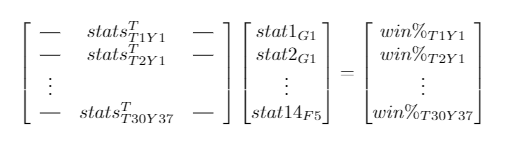


In [39]:

i = 0
while i < abbreviated_final_guards.num_rows//3-1:
  A_row = make_array()
  test_row = make_array()
  count = 0
  while count < 3:
    # for j in range(3,15):
    if i in random_indices:
      test_row = np.append(test_row,list(abbreviated_final_guards.rows[3*i+count][3:]))
    else:  
      A_row = np.append(A_row,list(abbreviated_final_guards.rows[3*i+count][3:]))

    count+=1
  count = 0
  while count < 5:
    # for j in range(3,15):
    if i in random_indices:
      test_row = np.append(test_row,list(abbreviated_final_forwards.rows[5*i+count][3:]))
    else:  
      A_row = np.append(A_row,list(abbreviated_final_forwards.rows[5*i+count][3:]))
    count+=1
  A_row = np.append(A_row,1)
  test_row = np.append(test_row,1)
  season = abbreviated_final_guards.column("Year").item(i*3)
  team = abbreviated_final_guards.column("Tm_2").item(i*3)

  if len(A)==0 and i not in random_indices:
    A = make_array(A_row)
  elif len(test_set) == 0 and i in random_indices:
    test_set = make_array(test_row)
  elif i not in random_indices:
    A = np.vstack([A,A_row])
  else:
    test_set = np.vstack([test_set,test_row])

  
 
  winrate = year_sorted_records.where("Season",season).where("Team",team).column("W/L%").item(0)
  if i not in random_indices:
    B = np.append(B,winrate)
  else:
    test_set_teams = np.append(test_set_teams,team)
    test_set_seasons = np.append(test_set_seasons,season)
    test_set_actual_winrates = np.append(test_set_actual_winrates,winrate)
  i+=1


  
#create A and B matrix from the abbreviated final guards/forwards 


Performing least squares to yield the solution $x$ vector that we denote as params

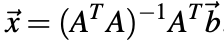

In [40]:
def doLeastSquares(A,b):
    x = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(A),A)),np.transpose(A)),b)
    return x;
params = doLeastSquares(A,B)
print(params)

[ 6.47622454e-03 -3.07981129e-02  3.99489907e-03 -5.17861902e-04
 -8.00288564e-03 -4.62155219e-03  1.29319575e-03 -3.37225039e-03
  1.16753333e-01  1.45548016e-03 -1.58613242e-02  9.02259794e-03
  1.07852526e-03  2.87130241e-01  4.24964623e-03  8.67642008e-04
  9.72800062e-03  1.22183076e-02 -1.20376738e-03 -1.49111451e-03
 -1.11635048e-01  1.37733652e-03  7.41255042e-03  5.54746992e-03
  3.40348957e-03 -1.71953133e-01 -4.86131098e-03 -1.95024222e-03
 -2.74227891e-03  1.04509846e-02  5.74713188e-03 -1.50062521e-03
  2.32271120e-01  1.05316773e-02 -6.84151052e-02  6.59298245e-03
 -1.30354905e-03 -2.28998196e-01 -2.47498555e-04  1.11688276e-03
 -1.01707125e-02  1.69741690e-03  2.22342853e-03  2.23852764e-03
  2.92505219e-01  8.25812949e-03  4.90678761e-02  1.53334715e-03
 -1.43415730e-02  3.68412059e-02  1.31175896e-03  1.17860696e-03
 -4.28161239e-03  8.76352349e-03 -3.16849815e-03  5.69284784e-03
  6.11567985e-01  1.42075055e-02  2.91841773e-03  7.62110768e-03
 -2.70007624e-03  9.64622

# Part 3: Testing the Model

Below, you can see the results from predicting the 2016-17 season. We defined an "Accurate" prediction as when the absolute difference between the actual and predicted winrates was within 10%. Below the table, you'll find the accuracy rate and some other insights. 

In [41]:
predictions = make_array()
for i in range(len(test_set)):
  predictions = np.append(predictions,np.dot(params,test_set[i]))
diffs = Table().with_columns("Season",test_set_seasons,"Team",test_set_teams,"Actual",test_set_actual_winrates,"Predicted",predictions,"Actual - Predicted",test_set_actual_winrates-predictions,"(Actual-Predicted)/Predicted",(predictions-test_set_actual_winrates)/test_set_actual_winrates)
accurate_diffs = diffs.with_columns("Accurate",abs(diffs.column("Actual - Predicted"))<.1)
outliers = accurate_diffs.with_columns("Accurate",abs(diffs.column("Actual - Predicted"))<.15).where("Accurate",False)

accurate_diffs.sort("Actual",descending=True).sort("Season").show(100)
print("Overall Accuracy Rate:" + str(np.count_nonzero(accurate_diffs.column("Accurate"))/accurate_diffs.num_rows))
print("Average (Actual-Predicted)/Predicted:" + str(np.average(abs(accurate_diffs.column("(Actual-Predicted)/Predicted")))))
print("Average Actual - Predicted:" + str(np.average(abs(accurate_diffs.column("Actual - Predicted")))))
print("Outliers: " + str(outliers.num_rows))


Season,Team,Actual,Predicted,Actual - Predicted,(Actual-Predicted)/Predicted,Accurate
2017,Golden State Warriors,0.817,0.882441,-0.0654414,0.0800996,True
2017,San Antonio Spurs,0.744,0.736131,0.00786924,-0.0105769,True
2017,Houston Rockets,0.671,0.469582,0.201418,-0.300176,False
2017,Boston Celtics,0.646,0.567418,0.0785816,-0.121643,True
2017,Utah Jazz,0.622,0.592717,0.0292832,-0.0470791,True
2017,Toronto Raptors,0.622,0.531931,0.090069,-0.144805,True
2017,Los Angeles Clippers,0.622,0.579472,0.0425279,-0.0683728,True
2017,Cleveland Cavaliers,0.622,0.673882,-0.051882,0.0834115,True
2017,Washington Wizards,0.598,0.346404,0.251596,-0.420729,False
2017,Oklahoma City Thunder,0.573,0.544198,0.0288015,-0.0502644,True


Overall Accuracy Rate:0.7333333333333333
Average (Actual-Predicted)/Predicted:0.16198418641834098
Average Actual - Predicted:0.07445825344444401
Outliers: 3


For the 2016-17 season, we achieved an average % difference of about 16% and an average absolute difference of about 7.4%. Other than a few bad predictions such as the Houston Rockets, Dallas Mavericks, and the Washington Wizards, the model produced many remarkably accurate winrate predictions for other teams this season.

Possible reasoning behind large errors could be that certain teams did not have an adequate number of guards or forwards on their team, or had a large amount of rookies. In our model, this causes these teams to be removed from the training set which could affect the overall accuracy. Also, some teams may not fit the 3 guard/5 forward mold, which could cause their winrate to be over or under predicted. 

# Part 4: Rating Top NBA Player Performances of All-Time

Aggregating weightings for each stat together for guards and forwards to create a weighted stats table that says how valuable each stat is to 
the win rate of his team.

(caption about how the weights are subjective to things like % and other factors invovled with specific stat)



In [42]:
weighted_stats_guards = {}
weighted_stats_forwards = {}
num_params = len(categories)-3
print(len(params))

categories[i%num_params+3]

for i in range(3*num_params):
  if categories[i%num_params+3] not in weighted_stats_guards:
    weighted_stats_guards[categories[i%num_params+3]] = params[i]*100
  else:
    weighted_stats_guards[categories[i%num_params+3]] += params[i]*100
for i in range(3*num_params,8*num_params):
  if categories[i%num_params+3] not in weighted_stats_forwards:
    weighted_stats_forwards[categories[i%num_params+3]] = params[i]*100*3/5
  else:
    weighted_stats_forwards[categories[i%num_params+3]] += params[i]*100*3/5

Table().with_columns("Stat",weighted_stats_guards.keys(),"Weight for Guards",weighted_stats_guards.values(),"Weight for Forwards",weighted_stats_forwards.values()).show(12)

97


Stat,Weight for Guards,Weight for Forwards
PER,1.09582,-0.589377
TS%,8.4379,-39.4812
TRB%,0.338323,-0.109216
AST%,-0.160046,0.0425792
STL%,-0.101716,-2.07405
BLK%,1.80477,0.910492
TOV%,0.583656,-0.0341372
USG%,-0.636399,0.460657
WS/48,23.7389,72.2817
BPM,1.33645,2.83521


Now, we use the stat weightings we just found and historical player data to produce a rating for every player's performance every season. After sorting by this overall rating, we get a ranking of top NBA player performances of all-time! 

It looks accurate at first (since the top guard peformances are dominated by Michael Jordan), but with a closer look, there are some imperfections and weird ratings such as Manu Ginobili (we have nothing against Manu, not a bad player at all but doesn't deserve a top spot in all-time rankings)



In [43]:
weighted_scores_guards = make_array()
def overall_score_guard(*args):
  return np.dot(np.array(args),np.array(list(weighted_stats_guards.values()))) 

def overall_score_forwards(*args):
  return np.dot(np.array(args),np.array(list(weighted_stats_forwards.values())))


overall_guards = abbreviated_final_guards.with_columns("Overall",abbreviated_final_guards.apply(overall_score_guard,abbreviated_final_guards.labels[3:]))
overall_forwards = abbreviated_final_forwards.with_columns("Overall",abbreviated_final_forwards.apply(overall_score_forwards,abbreviated_final_forwards.labels[3:]))
for key in weighted_stats_guards:
  overall_guards = overall_guards.with_columns(key,weighted_stats_guards[key]*overall_guards.column(key))
  overall_forwards = overall_forwards.with_columns(key,weighted_stats_forwards[key]*overall_forwards.column(key))

overall_guards.sort("Overall",descending = True).show(30)
overall_forwards.sort("Overall",descending = True).show(30)
  

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


Player,Year,Tm_2,PER,TS%,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS/48,BPM,FTr,Synergy,Overall
Stephen Curry 1989.0,2017,Golden State Warriors,34.5185,5.64495,2.90958,-5.39356,-0.305149,0.72191,7.52916,-20.7466,7.54898,16.7056,-1.9216,5.18387,52.3956
Michael Jordan* 1964.0,1990,Chicago Bulls,34.0801,5.18087,3.92455,-5.5536,-0.366179,2.16573,6.94551,-20.4284,6.93177,16.8393,-3.39738,4.23261,50.5549
Michael Jordan* 1964.0,1992,Chicago Bulls,34.628,5.10493,3.21407,-4.03316,-0.376351,3.06812,5.07781,-20.9375,7.6202,14.4337,-2.80553,5.18387,50.1781
Michael Jordan* 1964.0,1989,Chicago Bulls,34.7376,5.08805,2.63892,-4.32125,-0.396694,4.33146,5.6031,-21.7012,7.31159,16.3047,-3.30515,3.66555,49.9567
Magic Johnson* 1960.0,1990,Los Angeles Lakers,29.4777,5.27369,3.95838,-7.77825,-0.233948,0.72191,10.7393,-15.4645,6.3383,12.429,-3.80476,6.34892,48.0057
Magic Johnson* 1960.0,1991,Los Angeles Lakers,29.1489,5.24837,3.4509,-7.2821,-0.223776,1.26334,9.86379,-15.7827,6.40951,12.6963,-4.30438,6.69234,47.1805
Michael Jordan* 1964.0,1991,Chicago Bulls,34.1897,5.11337,3.51856,-4.57732,-0.356007,1.98525,5.71983,-21.4466,6.7656,14.1664,-2.73635,4.7322,47.0746
Stephen Curry 1989.0,2016,Golden State Warriors,30.6831,5.38338,2.36826,-6.17778,-0.305149,0.902387,8.34628,-18.3919,6.83681,13.2308,-1.92928,4.7322,45.6791
Michael Jordan* 1964.0,1997,Chicago Bulls,32.2172,4.91086,3.4509,-3.39298,-0.315321,1.80477,4.90271,-21.1921,7.52524,11.4935,-2.72867,6.69234,45.3685
Manu Ginobili 1978.0,2013,San Antonio Spurs,26.4094,5.63652,2.84192,-4.8494,-0.162746,1.98525,9.51359,-14.4463,6.10091,8.55328,-2.72098,6.34892,45.2103


Player,Year,Tm_2,PER,TS%,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS/48,BPM,FTr,Synergy,Overall
LeBron James 1985.0,2010,Cleveland Cavaliers,-18.6832,-23.3334,-1.29968,1.61801,-4.97772,2.18518,-0.375509,15.5702,22.9856,36.8578,3.1772,5.37865,39.1031
David Robinson* 1966.0,1995,San Antonio Spurs,-18.0939,-22.7806,-1.6164,0.91971,-4.77031,4.91666,-0.372095,14.741,21.3954,30.9038,3.75609,4.81081,33.8102
Shaquille O'Neal* 1973.0,2001,Los Angeles Lakers,-18.0349,-22.8201,-1.99866,0.821778,-1.24443,4.82561,-0.337958,14.3725,20.4557,27.5016,3.33202,4.81081,31.6839
LeBron James 1985.0,2011,Miami Heat,-18.3296,-23.8466,-1.2123,1.77981,-4.56291,1.82098,-0.419888,15.432,21.6122,35.4402,3.40606,0,31.1199
LeBron James 1985.0,2009,Cleveland Cavaliers,-17.1509,-22.4253,-1.2123,1.5882,-4.97772,1.91203,-0.389164,15.432,17.4922,31.7544,3.16373,4.81081,29.998
David Robinson* 1966.0,1998,San Antonio Spurs,-17.3277,-23.2544,-2.00958,0.621656,-3.94069,5.82715,-0.334545,13.2669,20.9617,26.084,4.01861,5.89202,29.8051
LeBron James 1985.0,2014,Miami Heat,-18.6243,-25.268,-1.43074,1.54988,-4.97772,1.72993,-0.423301,13.9118,23.2747,32.8885,2.65888,4.16629,29.456
Kevin Garnett 1977.0,2005,Minnesota Timberwolves,-17.3277,-21.5962,-2.19525,1.03893,-4.1481,3.64197,-0.358441,13.6354,19.6606,28.0686,1.94536,6.80352,29.1688
LeBron James 1985.0,2013,Miami Heat,-18.0939,-23.8861,-1.37613,1.43066,-5.39253,1.54784,-0.454025,14.741,21.5399,31.1873,2.88775,3.40176,27.5336
David Robinson* 1966.0,1999,San Antonio Spurs,-16.3847,-22.9386,-1.98774,0.677009,-2.90367,5.00771,-0.443784,13.6815,19.4438,22.1147,4.17343,6.36411,26.8038


# Conclusion:

Overall, we enjoyed working with historical NBA data and predicting team winrates using our least squares regression model. At the moment, we are only equipped with limited knowledge of data science and machine learning from only one semester of college studies. As we learn more and develop a more encapsulating understanding of these topics, we'll be able to further improve upon our existing work by incorporating more advanced machine learning strategies to create more fine-tuned, nuanced, and accurate models. 

Special Thanks to: Professors Gireeja Ranade, Swupnil Sahai, and David Wagner for exposure to key data science and machine learning fundamentals.